In [40]:
import requests
import time

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import requests_cache
import numpy as np

requests_cache.install_cache()

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

%matplotlib inline

In [41]:
# TODO: Add normalization of the song names (remove (feat. ...))
# TODO: Alternatively, load all songs from the artist and find out the mib to definitely find the song

# Artist & Song Dataframe

Load lyrics dataframe 

In [42]:
lyrics_df = pd.read_csv("../data/lyrics-data.csv")
artists_df = pd.read_csv('../data/artists-data.csv')

Show general information for the dataframes

In [43]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379931 entries, 0 to 379930
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ALink     379930 non-null  object
 1   SName     379928 non-null  object
 2   SLink     379930 non-null  object
 3   Lyric     379854 non-null  object
 4   language  365296 non-null  object
dtypes: object(5)
memory usage: 14.5+ MB


In [44]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4168 entries, 0 to 4167
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      4167 non-null   object 
 1   Genres      4163 non-null   object 
 2   Songs       4167 non-null   float64
 3   Popularity  4166 non-null   float64
 4   Link        4167 non-null   object 
dtypes: float64(2), object(3)
memory usage: 162.9+ KB


Create dataframe with song name and artist name (only English songs)

In [45]:
artists_songs_dataframe = pd.merge(artists_df, lyrics_df, how="inner", left_on="Link", right_on="ALink")
artists_songs_dataframe = artists_songs_dataframe[artists_songs_dataframe["language"] == "en"][["Artist", "SName"]]

In [46]:
artists_songs_dataframe.head()

,Artist,SName
69,Ivete Sangalo,Careless Whisper
86,Ivete Sangalo,Could You Be Loved / Citação Musical do Rap: S...
88,Ivete Sangalo,Cruisin' (Part. Saulo)
111,Ivete Sangalo,Easy
140,Ivete Sangalo,For Your Babies (The Voice cover)


In [47]:
# Number of English songs
print(f"Number of English songs: {artists_songs_dataframe['SName'].count()}")

# Number of all artists with English songs
print(f"Number of all artists with English songs: {artists_songs_dataframe['Artist'].nunique()}")

Number of English songs: 191385
Number of all artists with English songs: 2488


# LastFM API - Scraping Tags

Based on: https://www.dataquest.io/blog/last-fm-api-python/

In [48]:
API_KEY = 'b0fc842b94c2e6a0b4458c1686a24f61'
USER_AGENT = 'idsta_project'

In [49]:
def lastfm_get(payload):
    """Send a GET request to lastfm API to receive, e.g., song tags.

    :param payload: payload for the API request (contains, e.g., 'method', 'artist', 'track').
    
    :return: Response for the API request to lastfm.
    :rtype: requests.Response
    """
    
    # define headers and URL
    headers = {'user-agent': USER_AGENT}
    url = 'https://ws.audioscrobbler.com/2.0/'

    # Add API key and format to the payload
    payload['api_key'] = API_KEY
    payload['format'] = 'json'

    response = requests.get(url, headers=headers, params=payload)
    return response

Get top tags for all songs

In [50]:
def lookup_tags_for_artist_song(row):
    """Return a tags string containing all tags for a given artist and song.

    :param row: dataframe row consisting of columns 'Artist' and 'SName' specifying the artist and song name.
    
    :return: tags for a given artist and song.
    :rtype: String
    """
    
    artist, song = row["Artist"], row["SName"]
    
    response = lastfm_get({
        'method': 'track.getTopTags',
        'artist':  artist,
        'track': song
    })

    # if there's an error, just return nothing
    if response.status_code != 200 or "error" in response.text:
        return "NoSongFound"

    # extract the top tags and turn them into a string
    # TODO: Could later also look at track tag count
    tags = [t['name'] for t in response.json()['toptags']['tag']]
    tags_str = ', '.join(tags)
    if tags_str == "":
        tags_str ="NoTagsFound" 

    # rate limiting (to not get banned by lastfm API)
    if not getattr(response, 'from_cache', False):
        time.sleep(0.25)
    return tags_str

In [51]:
# Shorten artists_songs_dataframe for testing purposes
artists_songs_dataframe = artists_songs_dataframe[artists_songs_dataframe["Artist"] == "Eminem"]
artists_songs_dataframe.head()

,Artist,SName
170557,Eminem,Lose Yourself
170558,Eminem,The Real Slim Shady
170559,Eminem,Rap God
170560,Eminem,Without Me
170561,Eminem,Stan (feat. Dido)


In [52]:
# Scrape tags from lastfm for given songs of given artists (within the artists_songs_dataframe)
tqdm.pandas()
artists_songs_dataframe['Tags'] = artists_songs_dataframe[["Artist", "SName"]].progress_apply(lambda row: lookup_tags_for_artist_song(row), axis=1)

 45%|████████████████████████████████████████████████████████████████████████▌                                                                                        | 218/484 [00:00<00:00, 362.14it/s]/home/max/.local/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
 51%|███████████████████████████████████████████████████████████████████████████████████                                                                               | 248/484 [00:10<00:09, 24.47it/s]

KeyboardInterrupt



In [ ]:
artists_songs_dataframe.head(50)

# Preload Tags Dataframe

In [53]:
artists_songs_dataframe1 = pd.read_csv('../data/tags_first_third.csv')
artists_songs_dataframe2 = pd.read_csv('../data/tags_second_third.csv')
artists_songs_dataframe3 = pd.read_csv('../data/tags_third_third.csv')
artists_songs_dataframe = pd.concat([artists_songs_dataframe1, artists_songs_dataframe2, artists_songs_dataframe3])

artists_songs_dataframe.head(20)

,Artist,SName,Tags
0,Ivete Sangalo,Careless Whisper,NoTagsFound
1,Ivete Sangalo,Could You Be Loved / Citação Musical do Rap: S...,NoTagsFound
2,Ivete Sangalo,Cruisin' (Part. Saulo),NoTagsFound
3,Ivete Sangalo,Easy,"pop, female vocalists, rnb, hot, spanish, soul..."
4,Ivete Sangalo,For Your Babies (The Voice cover),NoSongFound
5,Ivete Sangalo,Human Nature,"pop, rock, female vocalists, dance, latin, rnb..."
6,Ivete Sangalo,Losing Control (Miss Cady feat. Ivete Sangalo),NoSongFound
7,Ivete Sangalo,Master Blaster (Jammin'),NoTagsFound
8,Ivete Sangalo,More Than Words,NoTagsFound
9,Ivete Sangalo,Natural Collie,"spanish, electronic, female, jazz, hip hop, po..."


Get statistics on how many songs were not found and how many had no tags

In [54]:
num_songs= len(artists_songs_dataframe["Tags"])
print(f"Number of songs that were scraped: {num_songs}")

num_songs_not_found = len(artists_songs_dataframe[artists_songs_dataframe["Tags"] == "NoSongFound"]["Tags"])
print(f"Number of songs that were not found in lastfm: {num_songs_not_found}")

num_songs_not_found = len(artists_songs_dataframe[artists_songs_dataframe["Tags"] == "NoTagsFound"]["Tags"])
print(f"Number of songs that had no tags in lastfm: {num_songs_not_found}")

Number of songs that were scraped: 191387
Number of songs that were not found in lastfm: 12584
Number of songs that had no tags in lastfm: 42056


# Mood keyword distribution

In [55]:
MOOD_CATEGORIES = {
    'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'],
    'sad': ['sadness', 'unhappy', 'melancholic', 'melancholy'],
    'happy': ['happy', 'happiness', 'happy songs', 'happy music'],
    'romantic': ['romantic', 'romantic music'],
    'upbeat': ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusiastic'],
    'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'],
    'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
    'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
    'dreamy': ['dreamy'],
    'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'],
    'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'],
    'aggression': ['aggression', 'aggressive'],
    'confident': ['confident', 'encouraging', 'encouragement', 'optimism'],
    'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
    'earnest': ['earnest', 'heartfelt'],
    'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'],
    'pessimism': ['pessimism', 'cynical', 'pessimistic', 'weltschmerz'],
    'excitement': ['excitement', 'exciting', 'exhilarating', 'thrill', 'ardor']
}

In [58]:
# This approach only counts a mood once per song, even if mutiple keywords of a mood are available in the tags
num_moods = len(MOOD_CATEGORIES)
song_distribution= dict(zip(MOOD_CATEGORIES.keys(), [0]*num_moods))

for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = str(tag_string).split(", ")
    for mood in MOOD_CATEGORIES:
        for keyword in MOOD_CATEGORIES[mood]:
            if keyword in tag_list:
                song_distribution[mood] += 1
                break

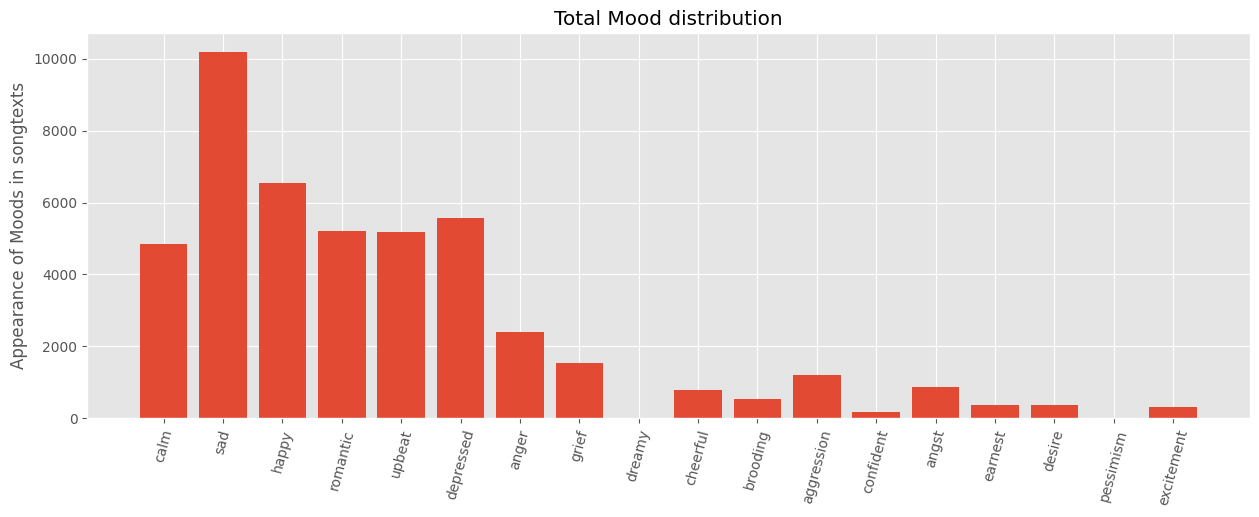

In [59]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = song_distribution.keys()
data = song_distribution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

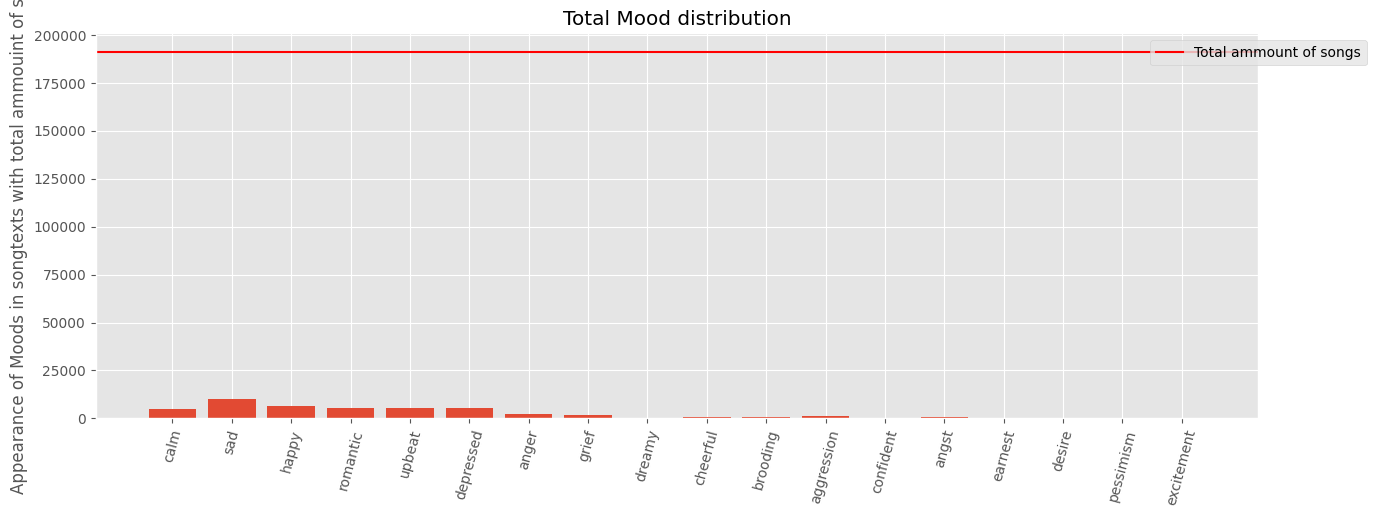

In [60]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = song_distribution.keys()
data = song_distribution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts with total ammouint of songs')
plt.title('Total Mood distribution')
plt.axhline(y = len(artists_songs_dataframe["Tags"]), color = 'r', linestyle = '-', label = "Total ammount of songs")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.show()

### Now we will calculate how many songs can be identified with a mood at all

In [61]:
songs_without_moods = 0

for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = str(tag_string).split(", ")
    flag = 0
    for mood in MOOD_CATEGORIES:
        for keyword in MOOD_CATEGORIES[mood]:
            if keyword in tag_list:
                flag = 1
                break
    if flag == 0:
        songs_without_moods += 1


Number of songs with mood: 28752, which is 15.02% of all songs.


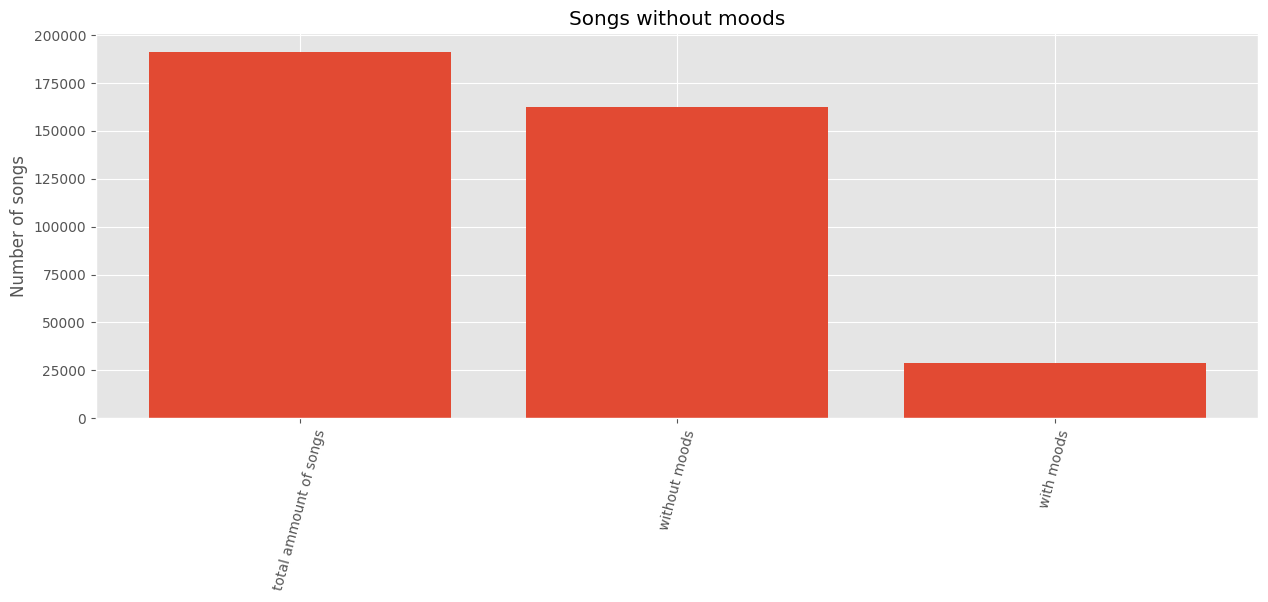

In [62]:
# the following figure shows the ammount of songs not containing any of the mood keywords

labels = ["total ammount of songs", "without moods", "with moods"]
songs_with_moood = len(artists_songs_dataframe["Tags"])-songs_without_moods
print(f"Number of songs with mood: {songs_with_moood}, which is {np.round(100*songs_with_moood/len(artists_songs_dataframe['Tags']), 2)}% of all songs.")
data = [ len(artists_songs_dataframe["Tags"]), songs_without_moods, songs_with_moood ]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Number of songs')
plt.title('Songs without moods')
plt.show()

# Mood keyword distribution (with advanced keyword set)

Concept based on: https://github.com/workmanjack/lyric-mood-classification

### Expanding the Categories

The last.fm dataset is generated by users without scientific rigor in mind. There is a chance that searching for an exact match on a mood and its related moods will not always yield all possible matches. In this section, we will explore additional tags that match with each category.

In [66]:
# TODO: Maybe add filters afterwards (e.g., for words like happy -> unhappy)

def find_tags_containing_keyword(df):
    """Return an advanced mood keyword dictionary based on our dataset and the base mood keywords (defined above).

    :param df: dataframe consisting of columns 'Artist', 'SName' and 'Tags' specifying the artist, song name and tags defined by users.
    
    :return: dictionary containing more mood keywords (values) for each mood (key) based on our dataset and the base mood keywords.
    :rtype: Dictionary
    """
    
    # Get all unique tags
    unique_tag_list = list(set([tag.lower() for tags in df["Tags"] for tag in str(tags).split(", ")]))
    
    # Check for each keyword of specific mood if this keyword is contained in the tags (do lower casing)
    advanced_mood_keyword_dict = {}
    for mood, keywords in MOOD_CATEGORIES.items():
        advanced_mood_keyword_dict[mood] = []
        for mood_keyword in keywords:
            for tag in unique_tag_list:
                if mood_keyword in tag:
                    advanced_mood_keyword_dict[mood].append(tag)
    
    return advanced_mood_keyword_dict

In [67]:
# TODO: Analyze mood keywords and look for missmatch (e.g., for words like happy -> unhappy)
# TODO: Create manual filters

advanced_mood_keyword_dict = find_tags_containing_keyword(artists_songs_dataframe)

print("Base mood keywords:")
print(MOOD_CATEGORIES)

print("Advanced mood keywords:")
print(advanced_mood_keyword_dict)

Base mood keywords:
{'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'], 'sad': ['sadness', 'unhappy', 'melancholic', 'melancholy'], 'happy': ['happy', 'happiness', 'happy songs', 'happy music'], 'romantic': ['romantic', 'romantic music'], 'upbeat': ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusiastic'], 'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'], 'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'], 'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'], 'dreamy': ['dreamy'], 'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'], 'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'], 'aggression': ['aggression', 'aggressive'], 'confident': ['confident', 'encouraging', 'encouragement', 'optimism'], 'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'], 'earnest': ['earnest', 'heartfelt'], 'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'], 'pessimism': 

### Advanced mood keywords distribution

In [71]:
# This approach only considers the first appearing mood keyword for the overall mood of the song
# --> Will assign the moods more sophisticatedly later in the project
song_distribution= dict(zip(advanced_mood_keyword_dict.keys(), [0]*num_moods))

for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = str(tag_string).split(", ")
    for mood in advanced_mood_keyword_dict:
        for keyword in advanced_mood_keyword_dict[mood]:
            if keyword in tag_list:
                song_distribution[mood] += 1
                break


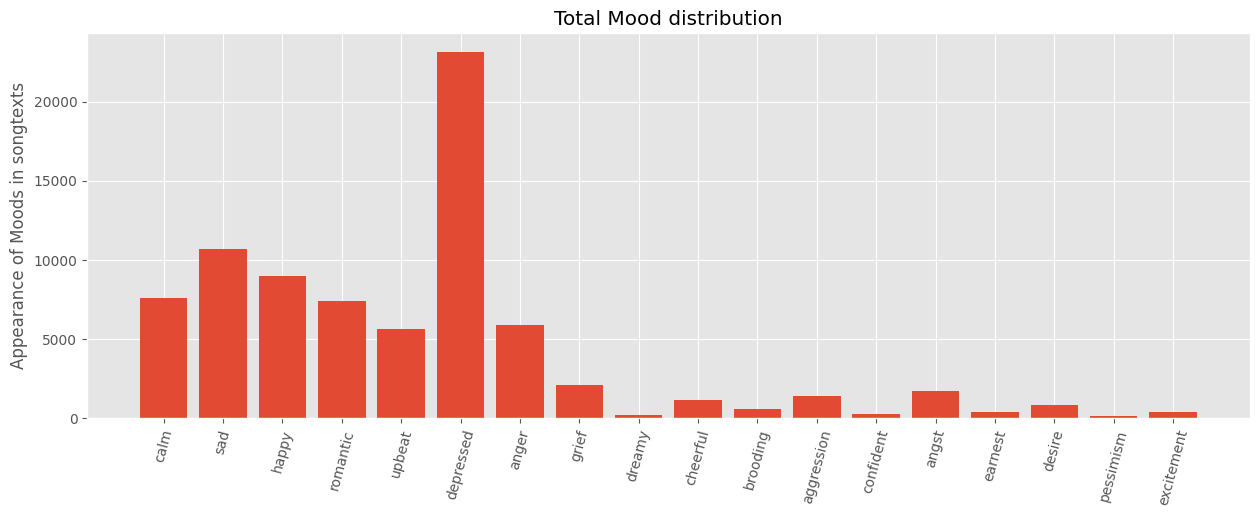

In [72]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = song_distribution.keys()
data = song_distribution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

#### Now plot the distribution with regards to the total ammount of songs

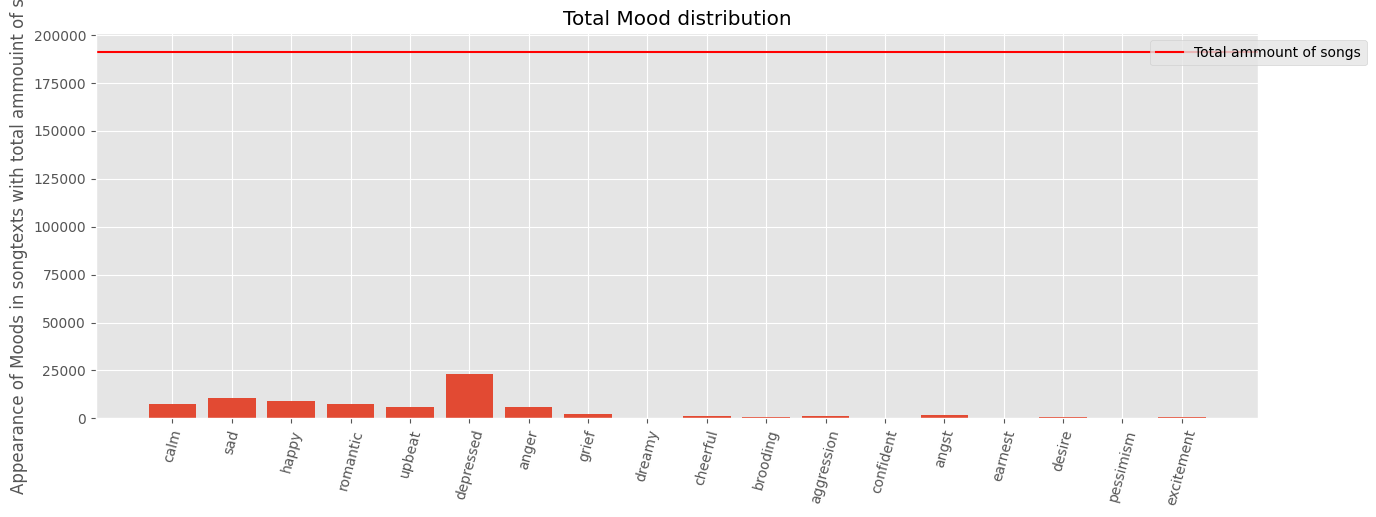

In [73]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = song_distribution.keys()
data = song_distribution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts with total ammouint of songs')
plt.title('Total Mood distribution')
plt.axhline(y = len(artists_songs_dataframe["Tags"]), color = 'r', linestyle = '-', label = "Total ammount of songs")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.show()

#### Now we will calculate how many songs can be identified with a mood at all

In [74]:
songs_without_moods = 0

for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = str(tag_string).split(", ")
    flag = 0
    for mood in advanced_mood_keyword_dict:
        for keyword in advanced_mood_keyword_dict[mood]:
            if keyword in tag_list:
                flag = 1
                break
    if flag == 0:
        songs_without_moods += 1


Number of songs with mood: 47052, which is 24.58% of all songs.


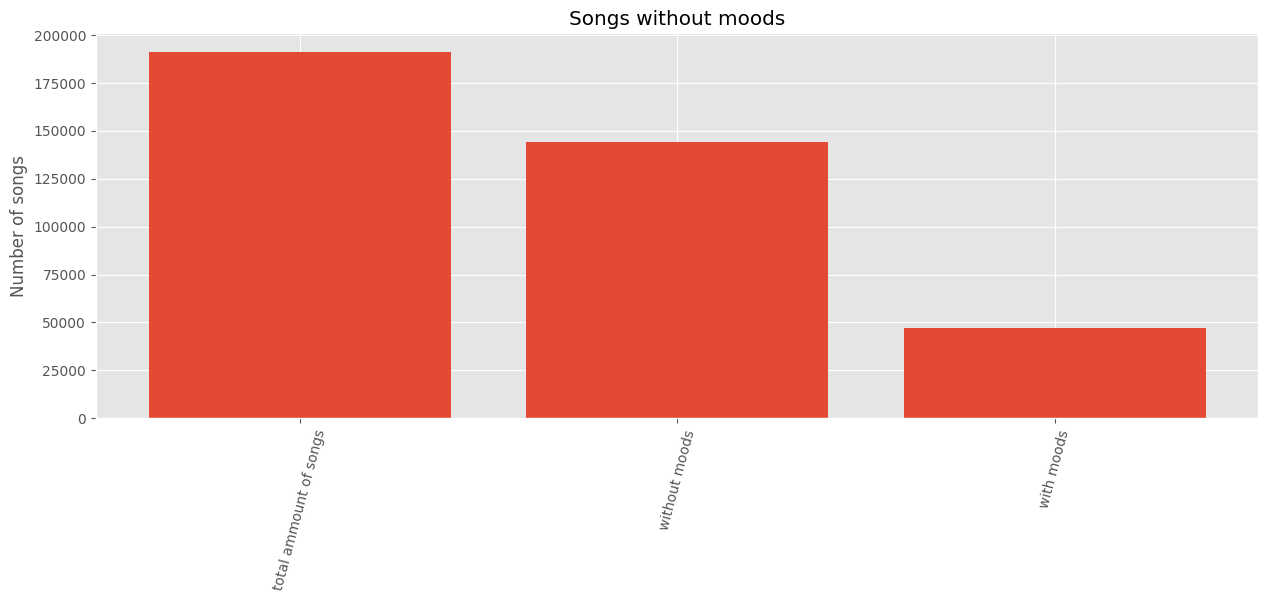

In [75]:
# the following figure shows the ammount of songs not containing any of the mood keywords

labels = ["total ammount of songs", "without moods", "with moods"]
songs_with_moood = len(artists_songs_dataframe["Tags"])-songs_without_moods
print(f"Number of songs with mood: {songs_with_moood}, which is {np.round(100*songs_with_moood/len(artists_songs_dataframe['Tags']), 2)}% of all songs.")
data = [ len(artists_songs_dataframe["Tags"]), songs_without_moods, songs_with_moood ]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Number of songs')
plt.title('Songs without moods')
plt.show()